In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi = obs[1][0], obs[1][1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax): ###graphbasedslam2draw
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw(xs, zlist, edges): #引数追加
    ax = make_ax()
    draw_observations(xs, zlist, ax)
    draw_trajectory(xs, ax)
    draw_edges(edges, ax) #追加
    plt.show()

In [3]:
def read_data():#データの読み込み
    hat_xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
    zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）

    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
                
        return hat_xs, zlist

In [4]:
class ObsEdge:  ###graphbasedslam4matrix
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]): #sensor_noise_rate追加
        assert z1[0] == z2[0] 

        self.t1, self.t2 = t1, t2  
        self.x1, self.x2 = xs[t1], xs[t2]
        self.z1, self.z2 = z1[1], z2[1]
        
        s1 = math.sin(self.x1[2] + self.z1[1]) 
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        ##誤差の計算##
        hat_e = self.x2 - self.x1 + np.array([
            self.z2[0]*c2 - self.z1[0]*c1, 
            self.z2[0]*s2 - self.z1[0]*s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while hat_e[2] >= math.pi: hat_e[2] -= math.pi*2
        while hat_e[2] <  -math.pi: hat_e[2] += math.pi*2
            
        ##精度行列の作成## 
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R1 = - np.array([[c1, -self.z1[0]*s1,  0],
                                     [s1,   self.z1[0]*c1, 0],
                                   [   0,                      1, -1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                                  [s2, self.z2[0]*c2,   0],
                                  [  0,                      1,  -1]])
        
        Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        Omega = np.linalg.inv(Sigma)
        
        print(Sigma)

In [5]:
import itertools
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [ObsEdge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges

[[ 0.12541578 -0.00496595  0.00054303]
 [-0.00496595  0.0174828   0.00882297]
 [ 0.00054303  0.00882297  0.01      ]]
[[ 0.21193083 -0.14192213  0.00957162]
 [-0.14192213  0.31788804  0.01053672]
 [ 0.00957162  0.01053672  0.01      ]]
[[ 0.19548551 -0.12110289  0.00863156]
 [-0.12110289  0.26220417  0.01024947]
 [ 0.00863156  0.01024947  0.01      ]]
[[ 0.16496596 -0.07748165  0.00614591]
 [-0.07748165  0.14288966  0.00974061]
 [ 0.00614591  0.00974061  0.01      ]]
[[ 0.16023894 -0.06377287  0.0050494 ]
 [-0.06377287  0.1034876   0.00975108]
 [ 0.0050494   0.00975108  0.01      ]]
[[ 0.11660836 -0.02344136  0.00281867]
 [-0.02344136  0.04188691  0.00825788]
 [ 0.00281867  0.00825788  0.01      ]]
[[ 0.09651109 -0.00930661  0.00191347]
 [-0.00930661  0.02534225  0.00712307]
 [ 0.00191347  0.00712307  0.01      ]]
[[ 0.08630317 -0.00238696  0.00147377]
 [-0.00238696  0.01907312  0.00609948]
 [ 0.00147377  0.00609948  0.01      ]]
[[ 0.22344506  0.14226925  0.00846139]
 [ 0.14226925  0.

 [-0.0082019   0.01284601  0.01      ]]
[[ 0.56392858 -0.04718093 -0.0073313 ]
 [-0.04718093  0.24036269  0.01072358]
 [-0.0073313   0.01072358  0.01      ]]
[[ 0.57716493 -0.11095199 -0.00555298]
 [-0.11095199  0.25243799  0.01086907]
 [-0.00555298  0.01086907  0.01      ]]
[[ 0.31402742 -0.13749887 -0.00375947]
 [-0.13749887  0.24911301  0.00706784]
 [-0.00375947  0.00706784  0.01      ]]
[[ 0.15665231  0.17178297 -0.02369604]
 [ 0.17178297  0.89007666  0.00527185]
 [-0.02369604  0.00527185  0.01      ]]
[[ 0.14066     0.16097001 -0.02055395]
 [ 0.16097001  0.70437923  0.00573934]
 [-0.02055395  0.00573934  0.01      ]]
[[ 0.17105003  0.18141619 -0.01940633]
 [ 0.18141619  0.65636383  0.00733855]
 [-0.01940633  0.00733855  0.01      ]]
[[ 0.80260841  0.1317922  -0.01346466]
 [ 0.1317922   0.59820122  0.01791734]
 [-0.01346466  0.01791734  0.01      ]]
[[ 0.61574169  0.0962084  -0.01259406]
 [ 0.0962084   0.57233682  0.01579491]
 [-0.01259406  0.01579491  0.01      ]]
[[ 0.62897804  0

<IPython.core.display.Javascript object>


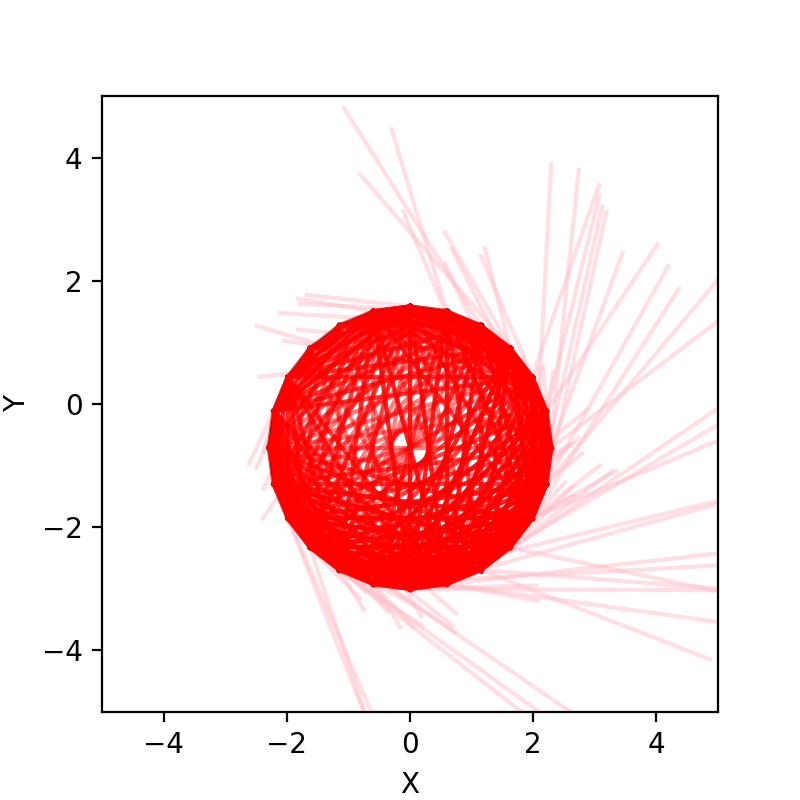

In [6]:
hat_xs, zlist = read_data()  ###graphbasedslam4exec
edges = make_edges(hat_xs, zlist)
draw(hat_xs, zlist, edges)